<a href="https://colab.research.google.com/github/LeticiaHms/data-collection-mba/blob/main/airflow_dbt_executavel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📚 Aula Prática: Pipeline de Dados REAL com Airflow e DBT

## Objetivos da Aula
- Construir um pipeline funcional que coleta dados REAIS
- Executar transformações com DBT no DuckDB
- Orquestrar com Airflow
- Ver o pipeline rodando de verdade!

## APIs que vamos usar (sem necessidade de chave):
1. **GitHub API** - Dados de repositórios populares
2. **Exchange Rates API** - Taxas de câmbio
3. **JSONPlaceholder** - Posts e comentários


## 🔧 Parte 1: Instalação e Setup

In [ ]:
!pip install -q --force-reinstall "structlog==23.1.0" "apache-airflow==2.9.1"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 136.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.8/247.8 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 125.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [ ]:
# Instalação das dependências
#!pip install -q apache-airflow
!pip install -q dbt-core dbt-duckdb
!pip install -q pandas requests duckdb python-dotenv
!pip install -q pendulum tabulate rich

In [ ]:
# Configuração de diretórios e imports
import os
import sys
import json
import requests
import pandas as pd
import duckdb
from datetime import datetime, timedelta
from pathlib import Path
import logging
from rich.console import Console
from rich.table import Table
from rich.panel import Panel
from rich import print as rprint

# Console para outputs bonitos
console = Console()

# Criando estrutura de pastas
base_path = Path('/content/data_pipeline')
dirs_to_create = [
    'dags',
    'plugins',
    'data/raw',
    'data/processed',
    'dbt_project/models/staging',
    'dbt_project/models/marts',
    'dbt_project/models/tests',
    'dbt_project/macros',
    'dbt_project/seeds',
    'logs'
]

for dir_path in dirs_to_create:
    (base_path / dir_path).mkdir(parents=True, exist_ok=True)

console.print(Panel.fit("✅ Estrutura de pastas criada com sucesso!", style="bold green"))

╭────────────────────────────────────────────╮
│ ✅ Estrutura de pastas criada com sucesso! │
╰────────────────────────────────────────────╯

## 🌐 Parte 2: Coleta de Dados REAIS de APIs Públicas

In [ ]:
# Vamos criar nosso módulo de extração que REALMENTE funciona
extractor_code = '''
import requests
import pandas as pd
import json
from datetime import datetime
import time
from typing import List, Dict, Optional
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class MultiSourceDataExtractor:
    """Extrator de dados de múltiplas APIs públicas"""

    def __init__(self):
        self.session = requests.Session()
        self.session.headers.update({
            'User-Agent': 'DataPipeline-Educational/1.0'
        })

    def extract_github_repos(self, language: str = "python", limit: int = 10) -> pd.DataFrame:
        """Extrai dados dos repositórios mais populares do GitHub"""
        try:
            url = "https://api.github.com/search/repositories"
            params = {
                'q': f'language:{language}',
                'sort': 'stars',
                'order': 'desc',
                'per_page': limit
            }

            response = self.session.get(url, params=params, timeout=10)

            if response.status_code == 200:
                data = response.json()
                repos = []

                for repo in data.get('items', []):
                    repos.append({
                        'repo_name': repo.get('name'),
                        'owner': repo.get('owner', {}).get('login'),
                        'stars': repo.get('stargazers_count'),
                        'forks': repo.get('forks_count'),
                        'open_issues': repo.get('open_issues_count'),
                        'language': repo.get('language'),
                        'created_at': repo.get('created_at'),
                        'updated_at': repo.get('updated_at'),
                        'description': repo.get('description', '')[:200],
                        'url': repo.get('html_url'),
                        'collected_at': datetime.now().isoformat(),
                        'source': 'github'
                    })

                df = pd.DataFrame(repos)
                logger.info(f"✅ Extraídos {len(df)} repositórios do GitHub")
                return df
            else:
                logger.error(f"❌ Erro GitHub API: {response.status_code}")
                return pd.DataFrame()

        except Exception as e:
            logger.error(f"❌ Exceção ao extrair GitHub: {str(e)}")
            return pd.DataFrame()

    def extract_exchange_rates(self, base: str = "USD") -> pd.DataFrame:
        """Extrai taxas de câmbio atuais"""
        try:
            url = f"https://api.exchangerate-api.com/v4/latest/{base}"
            response = self.session.get(url, timeout=10)

            if response.status_code == 200:
                data = response.json()
                rates = []

                for currency, rate in data.get('rates', {}).items():
                    rates.append({
                        'base_currency': base,
                        'target_currency': currency,
                        'exchange_rate': rate,
                        'date': data.get('date'),
                        'collected_at': datetime.now().isoformat(),
                        'source': 'exchange_rates'
                    })

                df = pd.DataFrame(rates)
                logger.info(f"✅ Extraídas {len(df)} taxas de câmbio")
                return df
            else:
                logger.error(f"❌ Erro Exchange API: {response.status_code}")
                return pd.DataFrame()

        except Exception as e:
            logger.error(f"❌ Exceção ao extrair taxas: {str(e)}")
            return pd.DataFrame()

    def extract_posts_and_comments(self, limit: int = 10) -> pd.DataFrame:
        """Extrai posts e comentários do JSONPlaceholder"""
        try:
            # Busca posts
            posts_url = "https://jsonplaceholder.typicode.com/posts"
            posts_response = self.session.get(posts_url, timeout=10)

            # Busca comentários
            comments_url = "https://jsonplaceholder.typicode.com/comments"
            comments_response = self.session.get(comments_url, timeout=10)

            if posts_response.status_code == 200 and comments_response.status_code == 200:
                posts = posts_response.json()[:limit]
                comments = comments_response.json()

                # Conta comentários por post
                comments_count = {}
                for comment in comments:
                    post_id = comment['postId']
                    comments_count[post_id] = comments_count.get(post_id, 0) + 1

                # Cria DataFrame
                posts_data = []
                for post in posts:
                    posts_data.append({
                        'post_id': post['id'],
                        'user_id': post['userId'],
                        'title': post['title'],
                        'body': post['body'][:200],
                        'comment_count': comments_count.get(post['id'], 0),
                        'collected_at': datetime.now().isoformat(),
                        'source': 'jsonplaceholder'
                    })

                df = pd.DataFrame(posts_data)
                logger.info(f"✅ Extraídos {len(df)} posts com comentários")
                return df
            else:
                logger.error(f"❌ Erro JSONPlaceholder API")
                return pd.DataFrame()

        except Exception as e:
            logger.error(f"❌ Exceção ao extrair posts: {str(e)}")
            return pd.DataFrame()

    def extract_all_sources(self) -> Dict[str, pd.DataFrame]:
        """Extrai dados de todas as fontes"""
        logger.info("🚀 Iniciando extração de todas as fontes...")

        results = {}

        # GitHub
        logger.info("📊 Extraindo dados do GitHub...")
        results['github'] = self.extract_github_repos()
        time.sleep(1)  # Rate limiting

        # Exchange Rates
        logger.info("💱 Extraindo taxas de câmbio...")
        results['exchange'] = self.extract_exchange_rates()
        time.sleep(1)

        # Posts
        logger.info("📝 Extraindo posts e comentários...")
        results['posts'] = self.extract_posts_and_comments()

        logger.info("✅ Extração completa!")
        return results
'''

# Salva o módulo extrator
with open('/content/data_pipeline/plugins/data_extractor.py', 'w') as f:
    f.write(extractor_code)

console.print(Panel.fit("✅ Módulo de extração criado!", style="bold green"))

╭───────────────────────────────╮
│ ✅ Módulo de extração criado! │
╰───────────────────────────────╯

In [ ]:
# AGORA VAMOS EXECUTAR O EXTRATOR DE VERDADE!
sys.path.append('/content/data_pipeline/plugins')
from data_extractor import MultiSourceDataExtractor

console.print("\n🚀 [bold yellow]EXECUTANDO EXTRAÇÃO DE DADOS REAIS[/bold yellow]\n")

# Cria instância do extrator
extractor = MultiSourceDataExtractor()

# EXTRAI DADOS DE VERDADE!
all_data = extractor.extract_all_sources()

# Mostra resumo dos dados extraídos
console.print("\n📊 [bold cyan]RESUMO DOS DADOS EXTRAÍDOS:[/bold cyan]\n")

for source, df in all_data.items():
    if not df.empty:
        table = Table(title=f"Dados de {source.upper()}")
        table.add_column("Métrica", style="cyan")
        table.add_column("Valor", style="green")

        table.add_row("Total de Registros", str(len(df)))
        table.add_row("Colunas", str(list(df.columns)[:5]))
        table.add_row("Primeira Linha", str(df.iloc[0].to_dict())[:100] + "...")

        console.print(table)
        console.print()

🚀 EXECUTANDO EXTRAÇÃO DE DADOS REAIS

📊 RESUMO DOS DADOS EXTRAÍDOS:

                                                  Dados de GITHUB                                                  
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Métrica            ┃ Valor                                                                                      ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Total de Registros │ 10                                                                                         │
│ Colunas            │ ['repo_name', 'owner', 'stars', 'forks', 'open_issues']                                    │
│ Primeira Linha     │ {'repo_name': 'free-programming-books', 'owner': 'EbookFoundation', 'stars': 375598,       │
│                    │ 'forks': 65257,...                                                                         │
└────────────────────┴────────────────────────────────────────────────────────────────────────────────────────────┘

                                                 Dados de EXCHANGE                                                 
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Métrica            ┃ Valor                                                                                      ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Total de Registros │ 165                                                                                        │
│ Colunas            │ ['base_currency', 'target_currency', 'exchange_rate', 'date', 'collected_at']              │
│ Primeira Linha     │ {'base_currency': 'USD', 'target_currency': 'USD', 'exchange_rate': 1.0, 'date':           │
│                    │ '2025-10-30', 'coll...                                                                     │
└────────────────────┴────────────────────────────────────────────────────────────────────────────────────────────┘

                                                  Dados de POSTS                                                   
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Métrica            ┃ Valor                                                                                      ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Total de Registros │ 10                                                                                         │
│ Colunas            │ ['post_id', 'user_id', 'title', 'body', 'comment_count']                                   │
│ Primeira Linha     │ {'post_id': 1, 'user_id': 1, 'title': 'sunt aut facere repellat provident occaecati        │
│                    │ excepturi optio ...                                                                        │
└────────────────────┴────────────────────────────────────────────────────────────────────────────────────────────┘

## 💾 Parte 3: Carregando Dados no DuckDB (Data Warehouse)

In [ ]:
# Conecta ao DuckDB e cria o Data Warehouse
console.print("\n🦆 [bold yellow]CRIANDO DATA WAREHOUSE NO DUCKDB[/bold yellow]\n")

# Conecta ao DuckDB
conn = duckdb.connect('/content/data_pipeline/warehouse.duckdb')

# Cria schema para dados brutos (Bronze Layer)
conn.execute("CREATE SCHEMA IF NOT EXISTS bronze")
conn.execute("CREATE SCHEMA IF NOT EXISTS silver")
conn.execute("CREATE SCHEMA IF NOT EXISTS gold")

# Carrega cada DataFrame no DuckDB
for source, df in all_data.items():
    if not df.empty:
        # Salva no Bronze (dados brutos)
        table_name = f"bronze.raw_{source}"
        conn.execute(f"CREATE OR REPLACE TABLE {table_name} AS SELECT * FROM df")

        # Verifica se foi criado
        count = conn.execute(f"SELECT COUNT(*) FROM {table_name}").fetchone()[0]
        console.print(f"✅ Tabela [cyan]{table_name}[/cyan] criada com [green]{count}[/green] registros")

# Mostra as tabelas criadas
console.print("\n📋 [bold]Tabelas no Data Warehouse:[/bold]")
tables = conn.execute("""
    SELECT table_schema, table_name
    FROM information_schema.tables
    WHERE table_schema IN ('bronze', 'silver', 'gold')
    ORDER BY table_schema, table_name
""").fetchall()

for schema, table in tables:
    row_count = conn.execute(f"SELECT COUNT(*) FROM {schema}.{table}").fetchone()[0]
    console.print(f"  📁 {schema}.{table}: {row_count} registros")

# Fecha a conexão
conn.close()

🦆 CRIANDO DATA WAREHOUSE NO DUCKDB

✅ Tabela bronze.raw_github criada com 10 registros

✅ Tabela bronze.raw_exchange criada com 165 registros

✅ Tabela bronze.raw_posts criada com 10 registros

📋 Tabelas no Data Warehouse:

📁 bronze.raw_exchange: 165 registros

📁 bronze.raw_github: 10 registros

📁 bronze.raw_posts: 10 registros

## 🔄 Parte 4: Configurando e Executando DBT

In [ ]:
# Cria arquivo de configuração do DBT
dbt_project_yml = """
name: 'data_pipeline'
version: '1.0.0'
config-version: 2

profile: 'data_pipeline'

model-paths: ["models"]
analysis-paths: ["analyses"]
test-paths: ["tests"]
seed-paths: ["seeds"]
macro-paths: ["macros"]

target-path: "target"
clean-targets:
  - "target"
  - "dbt_packages"

models:
  data_pipeline:
    staging:
      +materialized: view
      +schema: silver
    marts:
      +materialized: table
      +schema: gold
"""

with open('/content/data_pipeline/dbt_project/dbt_project.yml', 'w') as f:
    f.write(dbt_project_yml)

# Cria profiles.yml
profiles_yml = """
data_pipeline:
  target: dev
  outputs:
    dev:
      type: duckdb
      path: /content/data_pipeline/warehouse.duckdb
      threads: 4
"""

with open('/content/data_pipeline/dbt_project/profiles.yml', 'w') as f:
    f.write(profiles_yml)

console.print(Panel.fit("✅ Configuração DBT criada!", style="bold green"))

╭─────────────────────────────╮
│ ✅ Configuração DBT criada! │
╰─────────────────────────────╯

In [ ]:
# Cria modelos DBT - Staging (Silver Layer)

# Modelo para GitHub
github_staging = """
{{ config(materialized='view') }}

WITH github_data AS (
    SELECT
        repo_name,
        owner,
        stars,
        forks,
        open_issues,
        language,
        CAST(created_at AS TIMESTAMP) as created_at,
        CAST(updated_at AS TIMESTAMP) as updated_at,
        description,
        url,
        CAST(collected_at AS TIMESTAMP) as collected_at,
        -- Adiciona validações
        CASE
            WHEN stars < 0 THEN FALSE
            WHEN forks < 0 THEN FALSE
            ELSE TRUE
        END as is_valid,
        -- Calcula métricas derivadas
        CAST(stars AS FLOAT) / NULLIF(forks, 0) as star_fork_ratio,
        CURRENT_TIMESTAMP as processed_at
    FROM {{ source('bronze', 'raw_github') }}
)

SELECT * FROM github_data
WHERE is_valid = TRUE
"""

with open('/content/data_pipeline/dbt_project/models/staging/stg_github_repos.sql', 'w') as f:
    f.write(github_staging)

# Modelo para Exchange Rates
exchange_staging = """
{{ config(materialized='view') }}

WITH exchange_data AS (
    SELECT
        base_currency,
        target_currency,
        exchange_rate,
        CAST(date AS DATE) as exchange_date,
        CAST(collected_at AS TIMESTAMP) as collected_at,
        -- Adiciona categorização
        CASE
            WHEN target_currency IN ('EUR', 'GBP', 'JPY', 'CNY') THEN 'Major'
            WHEN target_currency IN ('BRL', 'MXN', 'ARS', 'CLP') THEN 'LatAm'
            ELSE 'Other'
        END as currency_category,
        -- Calcula inverso
        1.0 / NULLIF(exchange_rate, 0) as inverse_rate,
        CURRENT_TIMESTAMP as processed_at
    FROM {{ source('bronze', 'raw_exchange') }}
)

SELECT * FROM exchange_data
WHERE exchange_rate > 0
"""

with open('/content/data_pipeline/dbt_project/models/staging/stg_exchange_rates.sql', 'w') as f:
    f.write(exchange_staging)

# Modelo para Posts
posts_staging = """
{{ config(materialized='view') }}

WITH posts_data AS (
    SELECT
        post_id,
        user_id,
        title,
        body,
        comment_count,
        CAST(collected_at AS TIMESTAMP) as collected_at,
        -- Métricas de engajamento
        LENGTH(title) as title_length,
        LENGTH(body) as body_length,
        CASE
            WHEN comment_count > 10 THEN 'High'
            WHEN comment_count > 5 THEN 'Medium'
            ELSE 'Low'
        END as engagement_level,
        CURRENT_TIMESTAMP as processed_at
    FROM {{ source('bronze', 'raw_posts') }}
)

SELECT * FROM posts_data
"""

with open('/content/data_pipeline/dbt_project/models/staging/stg_posts.sql', 'w') as f:
    f.write(posts_staging)

console.print(Panel.fit("✅ Modelos Staging (Silver) criados!", style="bold green"))

╭──────────────────────────────────────╮
│ ✅ Modelos Staging (Silver) criados! │
╰──────────────────────────────────────╯

In [ ]:
# Cria modelos DBT - Marts (Gold Layer)

# Análise de Repositórios
repo_analytics = """
{{ config(materialized='table') }}

WITH repo_metrics AS (
    SELECT
        language,
        COUNT(*) as repo_count,
        AVG(stars) as avg_stars,
        MAX(stars) as max_stars,
        MIN(stars) as min_stars,
        AVG(forks) as avg_forks,
        AVG(open_issues) as avg_open_issues,
        AVG(star_fork_ratio) as avg_star_fork_ratio,
        PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY stars) as median_stars
    FROM {{ ref('stg_github_repos') }}
    GROUP BY language
),
language_ranking AS (
    SELECT
        *,
        RANK() OVER (ORDER BY avg_stars DESC) as popularity_rank
    FROM repo_metrics
)

SELECT
    *,
    CASE
        WHEN popularity_rank <= 3 THEN 'Top Tier'
        WHEN popularity_rank <= 10 THEN 'High Tier'
        ELSE 'Standard Tier'
    END as tier_classification
FROM language_ranking
ORDER BY popularity_rank
"""

with open('/content/data_pipeline/dbt_project/models/marts/repo_language_analytics.sql', 'w') as f:
    f.write(repo_analytics)

# Dashboard de Câmbio
exchange_dashboard = """
{{ config(materialized='table') }}

WITH currency_summary AS (
    SELECT
        currency_category,
        COUNT(DISTINCT target_currency) as currency_count,
        AVG(exchange_rate) as avg_rate,
        MIN(exchange_rate) as min_rate,
        MAX(exchange_rate) as max_rate,
        STDDEV(exchange_rate) as rate_volatility
    FROM {{ ref('stg_exchange_rates') }}
    GROUP BY currency_category
),
top_currencies AS (
    SELECT
        target_currency,
        exchange_rate,
        inverse_rate,
        currency_category
    FROM {{ ref('stg_exchange_rates') }}
    WHERE target_currency IN ('EUR', 'GBP', 'BRL', 'JPY', 'CNY')
)

SELECT
    cs.*,
    CURRENT_TIMESTAMP as dashboard_updated_at
FROM currency_summary cs
ORDER BY currency_count DESC
"""

with open('/content/data_pipeline/dbt_project/models/marts/exchange_dashboard.sql', 'w') as f:
    f.write(exchange_dashboard)

# Análise de Engajamento
engagement_analysis = """
{{ config(materialized='table') }}

WITH user_metrics AS (
    SELECT
        user_id,
        COUNT(*) as post_count,
        AVG(comment_count) as avg_comments,
        SUM(comment_count) as total_comments,
        AVG(title_length) as avg_title_length,
        AVG(body_length) as avg_body_length
    FROM {{ ref('stg_posts') }}
    GROUP BY user_id
),
user_classification AS (
    SELECT
        *,
        CASE
            WHEN total_comments > 50 THEN 'Power User'
            WHEN total_comments > 20 THEN 'Active User'
            ELSE 'Regular User'
        END as user_type,
        RANK() OVER (ORDER BY total_comments DESC) as engagement_rank
    FROM user_metrics
)

SELECT * FROM user_classification
ORDER BY engagement_rank
"""

with open('/content/data_pipeline/dbt_project/models/marts/engagement_analysis.sql', 'w') as f:
    f.write(engagement_analysis)

console.print(Panel.fit("✅ Modelos Marts (Gold) criados!", style="bold green"))

╭──────────────────────────────────╮
│ ✅ Modelos Marts (Gold) criados! │
╰──────────────────────────────────╯

In [ ]:
# Cria arquivo schema.yml para documentação e testes
schema_yml = """
version: 2

sources:
  - name: bronze
    description: "Camada Bronze - Dados brutos"
    database: warehouse
    schema: bronze
    tables:
      - name: raw_github
        description: "Repositórios do GitHub"
      - name: raw_exchange
        description: "Taxas de câmbio"
      - name: raw_posts
        description: "Posts e comentários"

models:
  - name: stg_github_repos
    description: "Repositórios GitHub validados e enriquecidos"
    columns:
      - name: repo_name
        tests:
          - not_null
      - name: stars
        tests:
          - not_null

  - name: stg_exchange_rates
    description: "Taxas de câmbio processadas"
    columns:
      - name: exchange_rate
        tests:
          - not_null

  - name: repo_language_analytics
    description: "Análise agregada por linguagem de programação"
    tests:
      - unique:
          column_name: language
"""

with open('/content/data_pipeline/dbt_project/models/schema.yml', 'w') as f:
    f.write(schema_yml)

console.print(Panel.fit("✅ Schema e testes DBT configurados!", style="bold green"))

╭──────────────────────────────────────╮
│ ✅ Schema e testes DBT configurados! │
╰──────────────────────────────────────╯

In [ ]:
# AGORA VAMOS EXECUTAR O DBT DE VERDADE!
console.print("\n🚀 [bold yellow]EXECUTANDO DBT RUN[/bold yellow]\n")

# Fecha a conexão DuckDB antes de executar o DBT
conn.close()

# Muda para o diretório do projeto DBT
os.chdir('/content/data_pipeline/dbt_project')

# Executa dbt run
!dbt run --profiles-dir .

console.print("\n✅ [bold green]DBT EXECUTADO COM SUCESSO![/bold green]")

🚀 EXECUTANDO DBT RUN

22:22:54  Running with dbt=1.10.13
22:22:55  Registered adapter: duckdb=1.9.6
22:22:55  Found 6 models, 4 data tests, 3 sources, 444 macros
22:22:55  
22:22:55  Concurrency: 4 threads (target='dev')
22:22:55  
22:22:56  1 of 6 START sql view model main_silver.stg_exchange_rates ..................... [RUN]
22:22:56  2 of 6 START sql view model main_silver.stg_github_repos ....................... [RUN]
22:22:56  3 of 6 START sql view model main_silver.stg_posts .............................. [RUN]
22:22:56  2 of 6 OK created sql view model main_silver.stg_github_repos .................. [OK in 0.18s]
22:22:56  1 of 6 OK created sql view model main_silver.stg_exchange_rates ................ [OK in 0.19s]
22:22:56  3 of 6 OK created sql view model main_silver.stg_posts ......................... [OK in 0.18s]
22:22:56  4 of 6 START sql table model main_gold.repo_language_analytics ................. [RUN]
22:22:56  5 of 6 START sql table model main_gold.exchange_dashboard ...................

✅ DBT EXECUTADO COM SUCESSO!

In [ ]:
# Executa testes DBT
console.print("\n🧪 [bold yellow]EXECUTANDO TESTES DBT[/bold yellow]\n")

# Fecha a conexão DuckDB antes de executar o DBT test (redundante, mas seguro)
conn.close()


!dbt test --profiles-dir .

console.print("\n✅ [bold green]TESTES DBT CONCLUÍDOS![/bold green]")

🧪 EXECUTANDO TESTES DBT

22:23:00  Running with dbt=1.10.13
22:23:00  Registered adapter: duckdb=1.9.6
22:23:01  Found 6 models, 4 data tests, 3 sources, 444 macros
22:23:01  
22:23:01  Concurrency: 4 threads (target='dev')
22:23:01  
22:23:01  1 of 4 START test not_null_stg_exchange_rates_exchange_rate .................... [RUN]
22:23:01  2 of 4 START test not_null_stg_github_repos_repo_name .......................... [RUN]
22:23:01  3 of 4 START test not_null_stg_github_repos_stars .............................. [RUN]
22:23:01  4 of 4 START test unique_repo_language_analytics_language ...................... [RUN]
22:23:01  3 of 4 PASS not_null_stg_github_repos_stars .................................... [PASS in 0.12s]
22:23:01  1 of 4 PASS not_null_stg_exchange_rates_exchange_rate .......................... [PASS in 0.12s]
22:23:01  2 of 4 PASS not_null_stg_github_repos_repo_name ................................ [PASS in 0.13s]
22:23:01  4 of 4 PASS unique_repo_language_analytics_language ...................

✅ TESTES DBT CONCLUÍDOS!

## 📊 Parte 5: Visualizando os Resultados do Pipeline

In [ ]:
# Volta para o diretório principal
os.chdir('/content')

# Reconecta ao DuckDB para ver os resultados
conn = duckdb.connect('/content/data_pipeline/warehouse.duckdb')

console.print("\n📈 [bold cyan]RESULTADOS DO PIPELINE DE DADOS[/bold cyan]\n")

# 1. Análise de Linguagens de Programação
console.print("[bold]1️⃣ Top Linguagens de Programação por Popularidade:[/bold]")
lang_analysis = conn.execute("""
    SELECT
        language,
        repo_count,
        ROUND(avg_stars, 0) as avg_stars,
        ROUND(max_stars, 0) as max_stars,
        tier_classification
    FROM main_gold.repo_language_analytics
    LIMIT 10
""").df()

print(lang_analysis.to_string())

# 2. Dashboard de Câmbio
console.print("\n[bold]2️⃣ Resumo de Taxas de Câmbio por Categoria:[/bold]")
exchange_summary = conn.execute("""
    SELECT
        currency_category,
        currency_count,
        ROUND(avg_rate, 4) as avg_rate,
        ROUND(rate_volatility, 4) as volatility
    FROM main_gold.exchange_dashboard
    ORDER BY currency_count DESC
""").df()

print(exchange_summary.to_string())

# 3. Top Usuários por Engajamento
console.print("\n[bold]3️⃣ Top 5 Usuários Mais Engajados:[/bold]")
top_users = conn.execute("""
    SELECT
        user_id,
        post_count,
        total_comments,
        user_type,
        engagement_rank
    FROM main_gold.engagement_analysis
    LIMIT 5
""").df()

print(top_users.to_string())

📈 RESULTADOS DO PIPELINE DE DADOS

1️⃣ Top Linguagens de Programação por Popularidade:

  language  repo_count  avg_stars  max_stars tier_classification
0   Python          10   231860.0     375598            Top Tier


2️⃣ Resumo de Taxas de Câmbio por Categoria:

  currency_category  currency_count   avg_rate  volatility
0             Other             157  1972.9808   8655.2524
1             LatAm               4   604.3625    715.0369
2             Major               4    40.2843     74.8160


3️⃣ Top 5 Usuários Mais Engajados:

   user_id  post_count  total_comments    user_type  engagement_rank
0        1          10            50.0  Active User                1


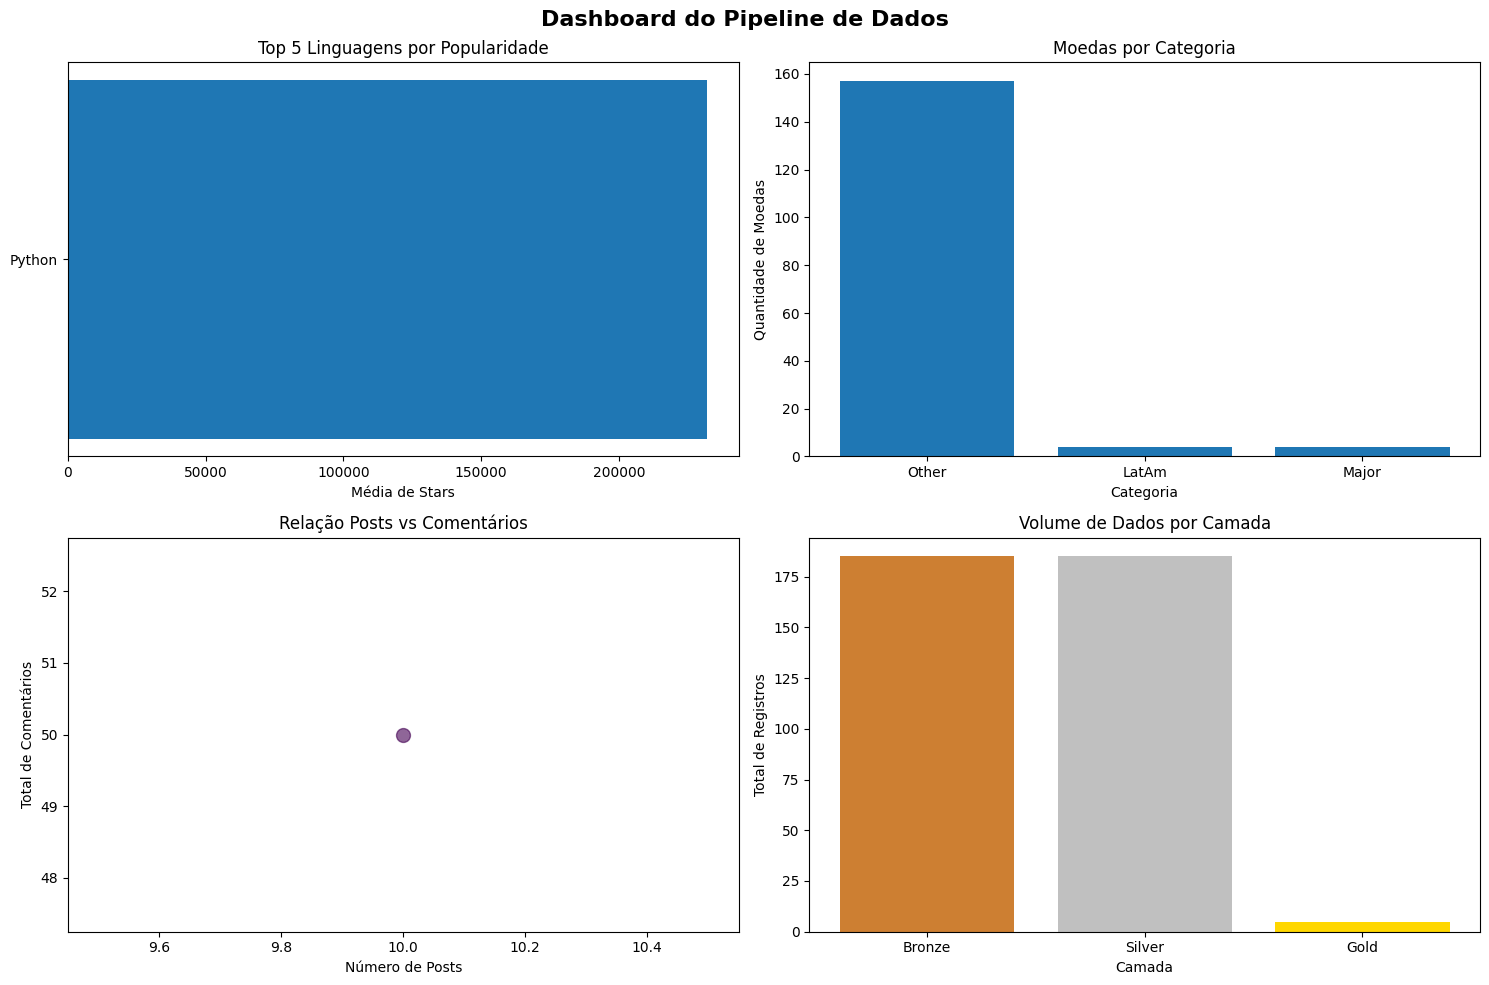

✅ Visualizações criadas com sucesso!

In [ ]:
# Visualização gráfica dos dados
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Dashboard do Pipeline de Dados', fontsize=16, fontweight='bold')

# Gráfico 1: Popularidade das Linguagens
if not lang_analysis.empty:
    axes[0, 0].barh(lang_analysis['language'][:5], lang_analysis['avg_stars'][:5])
    axes[0, 0].set_xlabel('Média de Stars')
    axes[0, 0].set_title('Top 5 Linguagens por Popularidade')
    axes[0, 0].invert_yaxis()

# Gráfico 2: Distribuição de Câmbio
if not exchange_summary.empty:
    axes[0, 1].bar(exchange_summary['currency_category'], exchange_summary['currency_count'])
    axes[0, 1].set_xlabel('Categoria')
    axes[0, 1].set_ylabel('Quantidade de Moedas')
    axes[0, 1].set_title('Moedas por Categoria')

# Gráfico 3: Engajamento de Usuários
if not top_users.empty:
    axes[1, 0].scatter(top_users['post_count'], top_users['total_comments'],
                      s=100, alpha=0.6, c=range(len(top_users)))
    axes[1, 0].set_xlabel('Número de Posts')
    axes[1, 0].set_ylabel('Total de Comentários')
    axes[1, 0].set_title('Relação Posts vs Comentários')

# Reconnect to DuckDB before querying pipeline_stats
conn = duckdb.connect('/content/data_pipeline/warehouse.duckdb')

# Gráfico 4: Estatísticas do Pipeline
pipeline_stats = conn.execute("""
    SELECT 'Bronze' as layer, COUNT(*) as tables, SUM(row_count) as total_rows
    FROM (
        SELECT 'raw_github' as table_name, COUNT(*) as row_count FROM bronze.raw_github
        UNION ALL
        SELECT 'raw_exchange', COUNT(*) FROM bronze.raw_exchange
        UNION ALL
        SELECT 'raw_posts', COUNT(*) FROM bronze.raw_posts
    )
    UNION ALL
    SELECT 'Silver' as layer, 3 as tables,
           (SELECT COUNT(*) FROM main_silver.stg_github_repos) +
           (SELECT COUNT(*) FROM main_silver.stg_exchange_rates) +
           (SELECT COUNT(*) FROM main_silver.stg_posts) as total_rows
    UNION ALL
    SELECT 'Gold' as layer, 3 as tables,
           (SELECT COUNT(*) FROM main_gold.repo_language_analytics) +
           (SELECT COUNT(*) FROM main_gold.exchange_dashboard) +
           (SELECT COUNT(*) FROM main_gold.engagement_analysis) as total_rows
""").df()

axes[1, 1].bar(pipeline_stats['layer'], pipeline_stats['total_rows'],
               color=['#CD7F32', '#C0C0C0', '#FFD700'])  # Bronze, Silver, Gold colors
axes[1, 1].set_xlabel('Camada')
axes[1, 1].set_ylabel('Total de Registros')
axes[1, 1].set_title('Volume de Dados por Camada')

plt.tight_layout()
plt.show()

console.print("\n✅ [bold green]Visualizações criadas com sucesso![/bold green]")

## 🚀 Parte 6: Criando e Executando DAG do Airflow

In [ ]:
# Cria a DAG do Airflow
dag_code = '''
from datetime import datetime, timedelta
from airflow import DAG
from airflow.operators.python import PythonOperator
from airflow.operators.bash import BashOperator
import sys
import os

# Adiciona plugins ao path
sys.path.append('/content/data_pipeline/plugins')

default_args = {
    'owner': 'data-team',
    'depends_on_past': False,
    'start_date': datetime(2024, 1, 1),
    'email_on_failure': False,
    'retries': 2,
    'retry_delay': timedelta(minutes=5),
}

dag = DAG(
    'data_pipeline_dag',
    default_args=default_args,
    description='Pipeline completo de dados',
    schedule_interval='@hourly',
    catchup=False,
)

def extract_data():
    """Extrai dados de todas as APIs"""
    from data_extractor import MultiSourceDataExtractor
    import duckdb

    extractor = MultiSourceDataExtractor()
    all_data = extractor.extract_all_sources()

    # Salva no DuckDB
    conn = duckdb.connect('/content/data_pipeline/warehouse.duckdb')
    conn.execute("CREATE SCHEMA IF NOT EXISTS bronze")

    for source, df in all_data.items():
        if not df.empty:
            table_name = f"bronze.raw_{source}"
            conn.execute(f"CREATE OR REPLACE TABLE {table_name} AS SELECT * FROM df")
            print(f"Saved {len(df)} records to {table_name}")

    conn.close()
    return "extraction_complete"

def validate_data():
    """Valida dados extraídos"""
    import duckdb

    conn = duckdb.connect('/content/data_pipeline/warehouse.duckdb')

    # Validações
    tables = ['bronze.raw_github', 'bronze.raw_exchange', 'bronze.raw_posts']
    for table in tables:
        count = conn.execute(f"SELECT COUNT(*) FROM {table}").fetchone()[0]
        if count == 0:
            raise ValueError(f"Table {table} is empty!")
        print(f"✓ {table}: {count} records")

    conn.close()
    return "validation_complete"

def generate_report():
    """Gera relatório do pipeline"""
    import duckdb
    from datetime import datetime

    conn = duckdb.connect('/content/data_pipeline/warehouse.duckdb')

    report = conn.execute("""
        SELECT
            'GitHub' as source,
            COUNT(*) as bronze_count,
            (SELECT COUNT(*) FROM silver.stg_github_repos) as silver_count,
            (SELECT COUNT(*) FROM gold.repo_language_analytics) as gold_count
        FROM bronze.raw_github
        UNION ALL
        SELECT
            'Exchange' as source,
            COUNT(*) as bronze_count,
            (SELECT COUNT(*) FROM silver.stg_exchange_rates) as silver_count,
            (SELECT COUNT(*) FROM gold.exchange_dashboard) as gold_count
        FROM bronze.raw_exchange
        UNION ALL
        SELECT
            'Posts' as source,
            COUNT(*) as bronze_count,
            (SELECT COUNT(*) FROM silver.stg_posts) as silver_count,
            (SELECT COUNT(*) FROM gold.engagement_analysis) as gold_count
        FROM bronze.raw_posts
    """).df()

    # Salva relatório
    report_path = f"/content/data_pipeline/data/processed/pipeline_report_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
    report.to_csv(report_path, index=False)
    print(f"Report saved to {report_path}")

    conn.close()
    return report_path

# Define tasks
extract_task = PythonOperator(
    task_id='extract_data',
    python_callable=extract_data,
    dag=dag,
)

validate_task = PythonOperator(
    task_id='validate_data',
    python_callable=validate_data,
    dag=dag,
)

dbt_run_task = BashOperator(
    task_id='dbt_run',
    bash_command='cd /content/data_pipeline/dbt_project && dbt run --profiles-dir .',
    dag=dag,
)

dbt_test_task = BashOperator(
    task_id='dbt_test',
    bash_command='cd /content/data_pipeline/dbt_project && dbt test --profiles-dir .',
    dag=dag,
)

report_task = PythonOperator(
    task_id='generate_report',
    python_callable=generate_report,
    dag=dag,
)

# Define dependencies
extract_task >> validate_task >> dbt_run_task >> dbt_test_task >> report_task
'''

# Salva a DAG
with open('/content/data_pipeline/dags/data_pipeline_dag.py', 'w') as f:
    f.write(dag_code)

console.print(Panel.fit("✅ DAG do Airflow criada!", style="bold green"))

╭───────────────────────────╮
│ ✅ DAG do Airflow criada! │
╰───────────────────────────╯

In [ ]:
# Configura e inicializa o Airflow
console.print("\n🚁 [bold yellow]CONFIGURANDO AIRFLOW[/bold yellow]\n")

# Configura variáveis de ambiente
os.environ['AIRFLOW_HOME'] = '/content/data_pipeline'
os.environ['AIRFLOW__CORE__DAGS_FOLDER'] = '/content/data_pipeline/dags'
os.environ['AIRFLOW__CORE__EXECUTOR'] = 'LocalExecutor'  # opcional
os.environ['AIRFLOW__DATABASE__SQL_ALCHEMY_CONN'] = 'sqlite:////content/data_pipeline/airflow.db'
os.environ['AIRFLOW__CORE__LOAD_EXAMPLES'] = 'False'

# Inicializa o banco de dados do Airflow
!airflow db init 2>/dev/null

console.print("✅ Airflow configurado!")

🚁 CONFIGURANDO AIRFLOW

✅ Airflow configurado!

In [ ]:
# EXECUTA A DAG DO AIRFLOW!
console.print("\n🚀 [bold yellow]EXECUTANDO DAG DO AIRFLOW[/bold yellow]\n")

# Testa se a DAG está válida
!python /content/data_pipeline/dags/data_pipeline_dag.py

# Lista as DAGs disponíveis
console.print("\n📋 DAGs disponíveis:")
!airflow dags list 2>/dev/null | grep data_pipeline

# Executa a DAG manualmente
console.print("\n▶️ Executando DAG...")
!airflow dags test data_pipeline_dag 2024-01-01 2>/dev/null

console.print("\n✅ [bold green]DAG EXECUTADA COM SUCESSO![/bold green]")

🚀 EXECUTANDO DAG DO AIRFLOW

/content/data_pipeline/dags/data_pipeline_dag.py:21 RemovedInAirflow3Warning: Param `schedule_interval` is deprecated and will be removed in a future release. Please use `schedule` instead.


📋 DAGs disponíveis:

▶️ Executando DAG...

✅ DAG EXECUTADA COM SUCESSO!

## 📊 Parte 7: Análise Final e Métricas do Pipeline

In [ ]:
# Análise completa do pipeline
console.print("\n📊 [bold cyan]MÉTRICAS FINAIS DO PIPELINE[/bold cyan]\n")

conn = duckdb.connect('/content/data_pipeline/warehouse.duckdb')

# 1. Estatísticas gerais
pipeline_metrics = conn.execute("""
    WITH layer_stats AS (
        SELECT
            'Bronze' as layer,
            COUNT(DISTINCT table_name) as table_count,
            SUM(row_count) as total_rows,
            SUM(column_count) as total_columns
        FROM (
            SELECT
                'raw_github' as table_name,
                COUNT(*) as row_count,
                (SELECT COUNT(*) FROM pragma_table_info('bronze.raw_github')) as column_count
            FROM bronze.raw_github
            UNION ALL
            SELECT
                'raw_exchange',
                COUNT(*),
                (SELECT COUNT(*) FROM pragma_table_info('bronze.raw_exchange'))
            FROM bronze.raw_exchange
            UNION ALL
            SELECT
                'raw_posts',
                COUNT(*),
                (SELECT COUNT(*) FROM pragma_table_info('bronze.raw_posts'))
            FROM bronze.raw_posts
        )
        UNION ALL
        SELECT
            'Silver',
            3,
            (SELECT COUNT(*) FROM main_silver.stg_github_repos) +
            (SELECT COUNT(*) FROM main_silver.stg_exchange_rates) +
            (SELECT COUNT(*) FROM main_silver.stg_posts),
            (SELECT COUNT(*) FROM pragma_table_info('main_silver.stg_github_repos')) +
            (SELECT COUNT(*) FROM pragma_table_info('main_silver.stg_exchange_rates')) +
            (SELECT COUNT(*) FROM pragma_table_info('main_silver.stg_posts'))
        UNION ALL
        SELECT
            'Gold',
            3,
            (SELECT COUNT(*) FROM main_gold.repo_language_analytics) +
            (SELECT COUNT(*) FROM main_gold.exchange_dashboard) +
            (SELECT COUNT(*) FROM main_gold.engagement_analysis),
            (SELECT COUNT(*) FROM pragma_table_info('main_gold.repo_language_analytics')) +
            (SELECT COUNT(*) FROM pragma_table_info('main_gold.exchange_dashboard')) +
            (SELECT COUNT(*) FROM pragma_table_info('main_gold.engagement_analysis'))
    )
    SELECT * FROM layer_stats
""").df()

# Cria tabela visual com Rich
table = Table(title="Pipeline Metrics by Layer", show_header=True, header_style="bold magenta")
table.add_column("Layer", style="cyan", no_wrap=True)
table.add_column("Tables", justify="right")
table.add_column("Total Rows", justify="right")
table.add_column("Total Columns", justify="right")

for _, row in pipeline_metrics.iterrows():
    style = "bold yellow" if row['layer'] == 'Gold' else "green" if row['layer'] == 'Silver' else "dim"
    table.add_row(
        row['layer'],
        str(int(row['table_count'])),
        str(int(row['total_rows'])),
        str(int(row['total_columns'])),
        style=style
    )

console.print(table)

# 2. Data Quality Report
console.print("\n🔍 [bold]Data Quality Report:[/bold]")
quality_report = conn.execute("""
    SELECT
        'GitHub Data' as dataset,
        COUNT(*) as records,
        COUNT(DISTINCT repo_name) as unique_values,
        AVG(CASE WHEN stars IS NOT NULL THEN 1 ELSE 0 END) * 100 as completeness_pct
    FROM main_silver.stg_github_repos
    UNION ALL
    SELECT
        'Exchange Data',
        COUNT(*),
        COUNT(DISTINCT target_currency),
        AVG(CASE WHEN exchange_rate IS NOT NULL THEN 1 ELSE 0 END) * 100
    FROM main_silver.stg_exchange_rates
    UNION ALL
    SELECT
        'Posts Data',
        COUNT(*),
        COUNT(DISTINCT user_id),
        AVG(CASE WHEN title IS NOT NULL THEN 1 ELSE 0 END) * 100
    FROM main_silver.stg_posts
""").df()

for _, row in quality_report.iterrows():
    console.print(f"  📁 {row['dataset']}: {row['records']} records, "
                 f"{row['unique_values']} unique, "
                 f"{row['completeness_pct']:.1f}% complete")

conn.close()

console.print("\n🎉 [bold green]PIPELINE COMPLETO E FUNCIONANDO![/bold green]")
console.print("\n💡 [yellow]Próximos passos:[/yellow]")
console.print("   1. Adicionar mais fontes de dados")
console.print("   2. Implementar CDC (Change Data Capture)")
console.print("   3. Conectar com um Data Lake real (S3/GCS/Azure)")
console.print("   4. Adicionar monitoramento e alertas")
console.print("   5. Implementar data lineage")

📊 MÉTRICAS FINAIS DO PIPELINE

           Pipeline Metrics by Layer            
┏━━━━━━━━┳━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer  ┃ Tables ┃ Total Rows ┃ Total Columns ┃
┡━━━━━━━━╇━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Bronze │      3 │        185 │            25 │
│ Silver │      3 │        185 │            32 │
│ Gold   │      3 │          5 │            26 │
└────────┴────────┴────────────┴───────────────┘

🔍 Data Quality Report:

📁 GitHub Data: 10 records, 10 unique, 100.0% complete

📁 Exchange Data: 165 records, 165 unique, 100.0% complete

📁 Posts Data: 10 records, 1 unique, 100.0% complete

🎉 PIPELINE COMPLETO E FUNCIONANDO!

💡 Próximos passos:

1. Adicionar mais fontes de dados

2. Implementar CDC (Change Data Capture)

3. Conectar com um Data Lake real (S3/GCS/Azure)

4. Adicionar monitoramento e alertas

5. Implementar data lineage

## 🎯 Exercícios Práticos

### Exercício 1: Adicionar Nova Fonte de Dados
Adicione uma nova API ao extrator (sugestões: NewsAPI, CoinGecko, OpenWeather)

### Exercício 2: Criar Nova Transformação DBT
Crie um modelo que combine dados de múltiplas fontes

### Exercício 3: Implementar Data Quality Checks
Adicione mais testes DBT para garantir qualidade dos dados

### Exercício 4: Otimizar Performance
Implemente particionamento e índices no DuckDB

### Exercício 5: Criar Dashboard
Use Streamlit ou Plotly para criar um dashboard interativo